In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import ipyvolume as ipv

In [5]:
import kelp_compute
import kelp_analyze
import discrete_plot

In [6]:
import sqlite3
import shutil
import os

In [37]:
def cori_get_fd_vs_best_grid_study_onespace_errors(study_name):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    perceived_irrad_dict, abs_err_arr, rel_err_arr, compute_time_dict = (
        kelp_analyze.grid_study_analyze_fd_vs_best_onespace(db_path, study_name)
    )
    
    # TODO: Do plot, not just return errors
    #return ipv.quickvolshow(abs_err_arr),
    return abs_err_arr, rel_err_arr

In [38]:
def cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name):
    base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
    study_dir = os.path.join(base_dir, study_name)
    db_path = os.path.join(study_dir, '{}.db'.format(study_name))
    perceived_irrad_dict, abs_err_arr, rel_err_arr, compute_time_dict = (
        kelp_analyze.grid_study_analyze_fd_vs_noscat_onespace(db_path, study_name)
    )
    
    # TODO: Do plot, not just return errors
    #return ipv.quickvolshow(abs_err_arr),
    return abs_err_arr, rel_err_arr

In [98]:
def plot_two_edges(rel_err_arr, abs_err_arr, ns_list, na_list):
    plt.figure(figsize=(10,4))
    
    ax1 = plt.subplot(1,2,1)
    ax1.semilogy(na_list, rel_err_arr[-1,:], 'C1o-', label='na')
    ax1.set_xlabel('na')
    plt.legend(loc='lower right')

    ax2 = plt.twiny()
    ax2.semilogy(ns_list, rel_err_arr[:,-1], 'C0o-', label='ns')
    ax2.set_xlabel('ns')
    plt.legend(loc='upper right')

    ax1.set_ylabel('Average relative error (Perceived Irradiance)')
    
    ax3 = plt.subplot(1,2,2)
    ax3.semilogy(na_list, abs_err_arr[-1,:], 'C1o-', label='na')
    ax3.set_xlabel('na')
    plt.legend(loc='lower right')

    ax4 = plt.twiny()
    ax4.semilogy(ns_list, abs_err_arr[:,-1], 'C0o-', label='ns')
    ax4.set_xlabel('ns')
    plt.legend(loc='upper right')
    
    ax3.set_ylabel('Average absolute error (Perceived Irradiance)')
    
    plt.tight_layout()

In [242]:
def plot_2d_resolution_grid(rel_err_arr, abs_err_arr, ns_list, na_list):
    # ns max
    plt.figure(figsize=(10,8))
    ax = plt.gca()
    #ax.set_aspect(4)
    
    plt.title('log10 rel err (Perceived Irradiance)')
    rel_err_ns_plane = rel_err_arr
    discrete_plot.imshow_with_contours_and_zoom(
        ns_list, 
        na_list, 
        rel_err_ns_plane, 
        zoom_factor=4,
        imshow_kwargs={
            'norm': LogNorm(),
            #'vmin': 1e-2,
            #'vmax': 1e0
        },
        contour_kwargs={
            #'levels': np.logspace(-2,0,5),
            'norm': LogNorm()
        },
        cbar_kwargs={
            'label': 'average relative error',
        }

    )
    ax.set_xlabel('ns')
    ax.set_ylabel('na')

In [179]:
def plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list):
    plot_two_edges(rel_err_arr, abs_err_arr, ns_list, na_list)
    plot_2d_resolution_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

# General

## Compare Two

abs_err = 2.492e-01
rel_err = 4.463e-02


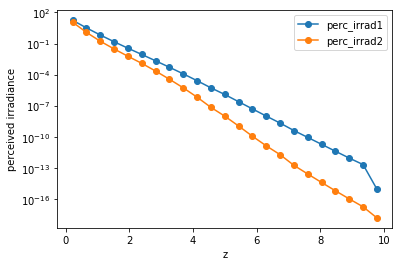

In [264]:
kelp_analyze.cori_plot_two_avg_irrads_onespace(
    'gs64_a01_b0_small',
    {'ns': 23, 'na': 10, 'fd_flag': True},
    {'ns': 23, 'na': 10, 'fd_flag': False},
)
plt.yscale('log')

# FD vs. True ($b=0$)

## Converging

In [139]:
ns_list = np.arange(8, 89, 8)
na_list = np.arange(2, 9, 2)
study_name = 'gs88_a01_b0'

In [68]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

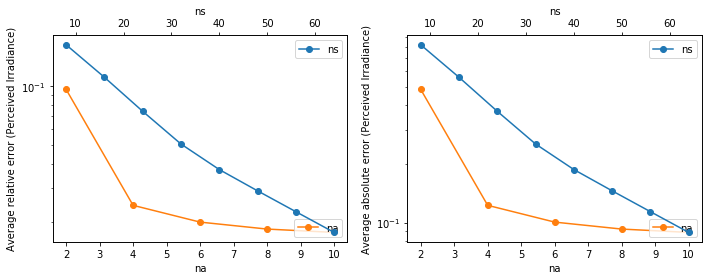

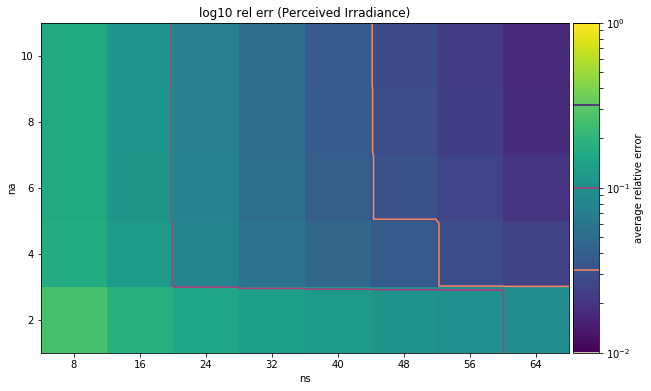

In [207]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## Non-converging

In [213]:
ns_list = np.arange(8, 24)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a01_b0_small'

In [214]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

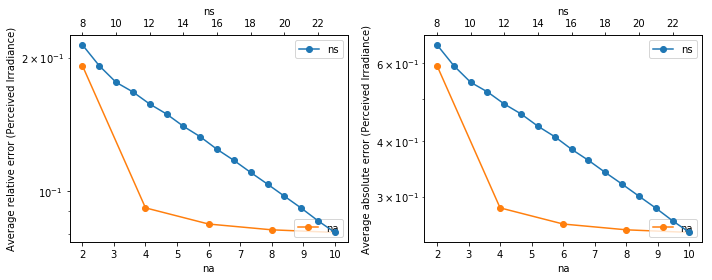

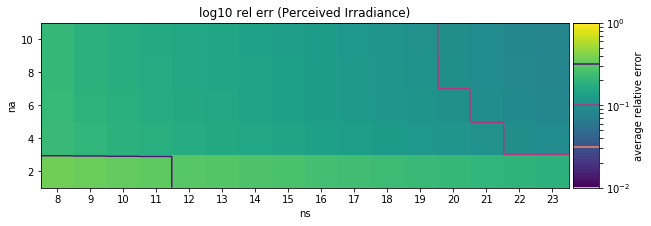

In [215]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

##  $a_w \gg 1$

In [216]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a50_b0'

In [217]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

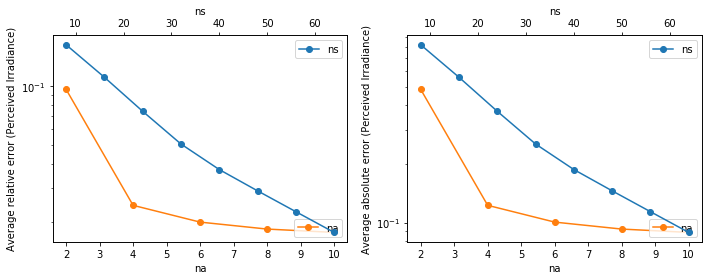

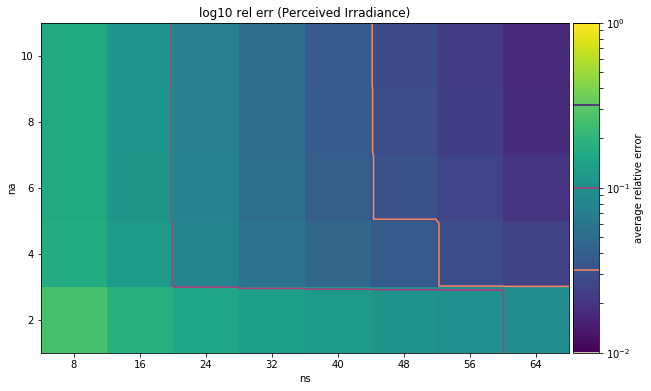

In [218]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

##  Bottom-heavy

In [219]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a01_b0_bh'

In [220]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_noscat_grid_study_onespace_errors(study_name)

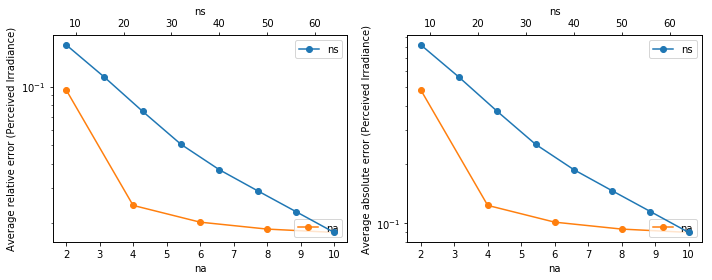

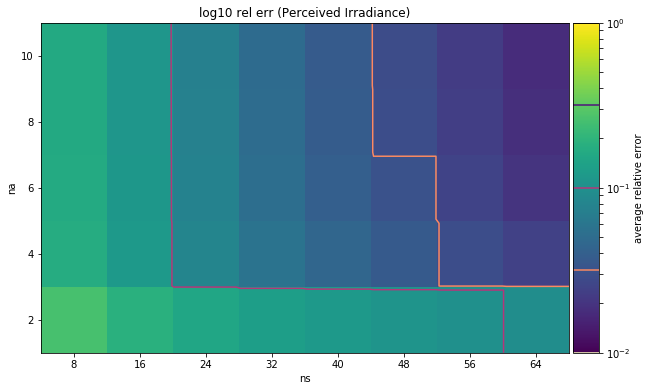

In [221]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

# FD vs. FD

## Converging, $b=0$

In [239]:
ns_list = np.arange(8, 89, 8)
na_list = np.arange(2, 9, 2)
study_name = 'gs88_a01_b0'

In [240]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

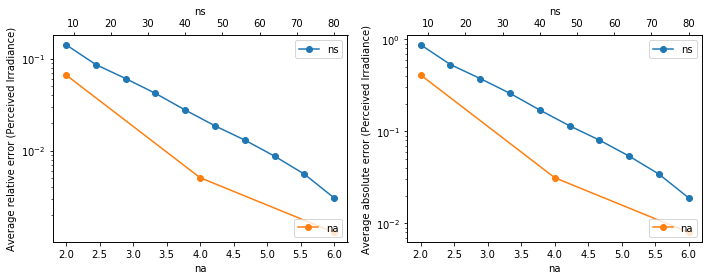

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


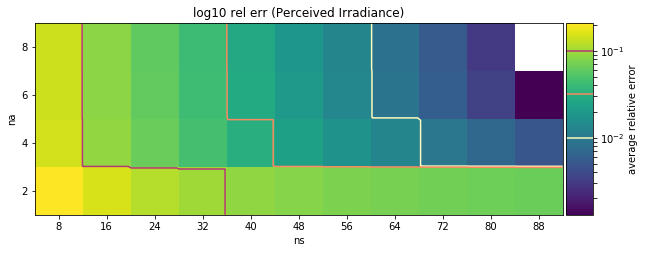

In [241]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## Non-converging, $b=0$

In [244]:
ns_list = np.arange(8, 24)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_a01_b0_small'

In [245]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

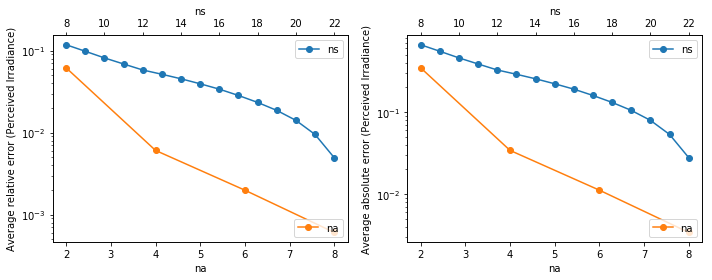

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


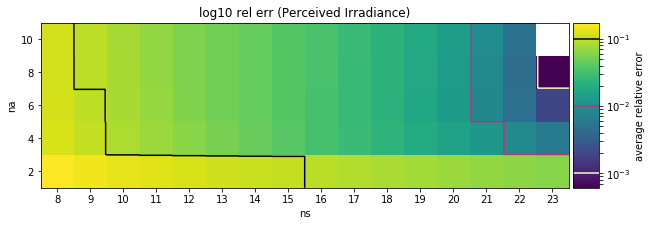

In [246]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## $b \neq 0$

In [255]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_top_heavy'

In [256]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

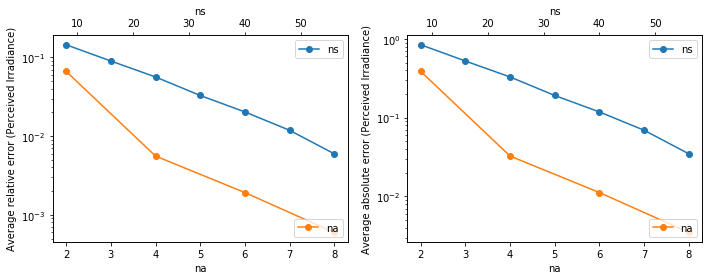

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


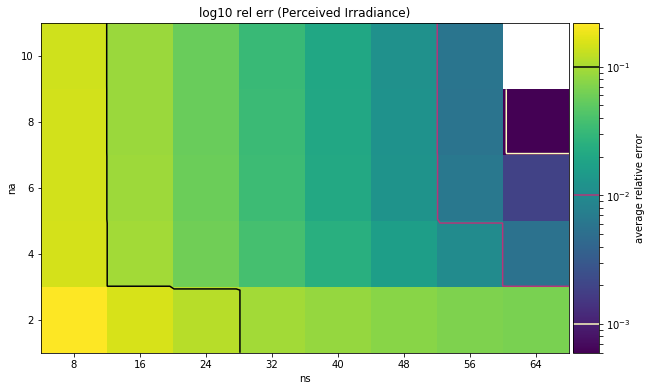

In [257]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)

## $b \gg 1$

In [258]:
ns_list = np.arange(8, 65, 8)
na_list = np.arange(2, 11, 2)
study_name = 'gs64_nuc2200'

In [259]:
abs_err_arr, rel_err_arr = cori_get_fd_vs_best_grid_study_onespace_errors(study_name)

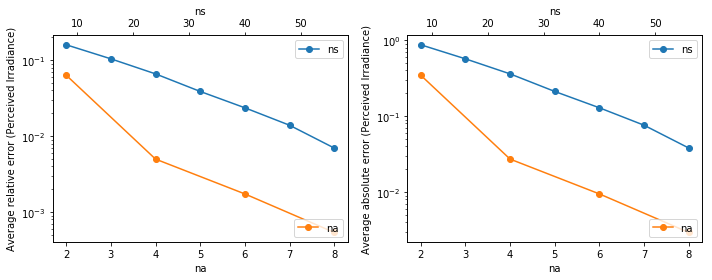

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/matplotlib/colors.py:929: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


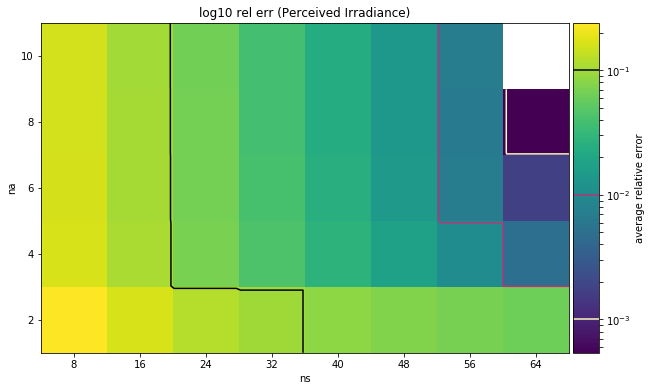

In [260]:
plot_gs_edges_and_grid(rel_err_arr, abs_err_arr, ns_list, na_list)